# <center>Lab 4: Feature Selection and Coordinate Descent</center>
<center>DATA 558, Spring 2021</center>
<center>TAs: Alec Greaves-Tunnell and Ronak Mehta</center>

## 0. Overview

In this lab, we will cover:
- Feature selection via LASSO and forward stepwise selection
- Hyperparameter selection via K-fold cross-validation
- Optimization via coordinate descent

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

%matplotlib inline

## 1. Feature Selection

In this section, we cover an alternate view on regularization that has scientific and computational advantages over previous methods.

### 1.1. Background
- Based on the previous section and Lab 3, we saw that when data is centered, scaled, and encoded appropriately, we no longer need to consider an intercept term. We will now just use $d$ to describe the number of features, and the design matrix $X \in \mathbb{R}^{n \times d}$ will not be assumed to contain a column of ones.
- We saw in Lab 2 that issues can arise in high-dimensional data ($d \gg n$ or even $d \approx n$), namely overfitting and computational burden. Consider two examples.
    - **Example 2.1**: $X_{ij} = $ expression level of the $j$-th gene in the $i$-th genome, $y_i = $ presence or absence of a disease in patient $i$. 
    - **Example 2.2**: $X_{ij} = $ represents the frequency of word $j$ in the $i$-th email, and $y_i = $ whether $i$-th email is spam.
- In Labs 2 and 3, we presented $\ell^2$ regularization for both least-squares and logistic regression to mitigate these issues.
- There are two main disadvantages to the previous approaches.
    - **Interpretation**: Cannot answer the questions "Which genes contribute most to the disease?" or "Which word is the most relevant for identifying spam?".
    - **Computational**: Must still include all $d$ variables in the model, which is particularly burdensome if the model is evaluated many times.

To address this shortcoming, we introduce *linear feature selection methods*. These methods, while in the process of picking $\beta \in \mathbb{R}^d$ such that $\beta^\top x$ is close to $y$, will also return a *subset* of the $d$ features that are the only ones used in the prediction. Where as $\ell^2$ regularization will shrink the values of the $\beta$ vector, these new methods will set some of them to zero, and only have nonzero coefficients for the most important features.

### 1.2. The LASSO

Give dataset $(x_1, y_1), ..., (x_n, y_n)$, the LASSO objective is defined as
$$
L_1(\beta) = \frac{1}{2n} \sum_{i=1}^n (y_i - \beta^\top x_i)^2 + \lambda ||\beta||_1,
$$
where
$$
||\beta||_1 = \sum_{j=1}^d |\beta_j|
$$
is called the $\ell^1$ (pronounced "ell 1") norm of $\beta$. 
![norms](img/norms.jpeg)

In [2]:
ad_data = pd.read_csv('Advertising.csv', index_col=0)
ad_data.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [3]:
X_full = ad_data[["TV", "Newspaper"]].to_numpy()
y_full = ad_data["Sales"].to_numpy()

**Exercise 1.1**: Use `sklearn` to split the data 80/20 into a train and test set, and center and scale `X`. Do not provide a `random_state`.

In [4]:
np.random.seed(123)

## <YOUR CODE HERE>
# Import correct methods.
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Split the data into train and test set.
## <YOUR CODE HERE>
X, X_test, y, y_test = train_test_split(X_full, y_full, test_size=0.20) 

# Standardize the train and test design matrix.
## <YOUR CODE HERE>
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [5]:
def plot_objective(X, y, beta=None, beta_r=None, beta_l=None, l1=None, l2=None):
    nb = 100
    brange = np.linspace(-10, 10, nb)
    b1, b2 = np.meshgrid(brange, brange)
    
    def obj(beta_, X, y):
        return 0.5 * np.dot(y - np.dot(X, beta_), y - np.dot(X, beta_)) / len(X)
    z = np.array([obj(x, X, y) for x in zip(b1.ravel(), b2.ravel())])
    
    # TODO: adjust levels to match the solutions.
    levels=np.logspace(-5,4,100)
    
    plt.figure(figsize=(6,6))
    
    plt.hlines(y=0, xmin=-10, xmax=10, color='k')
    plt.vlines(x=0, ymin=-10, ymax=10, color='k')
    
    labels = False
    if beta is not None:
        plt.scatter(beta[0], beta[1], marker="x", s=100, color='k', label="LR")
        labels = True
    if beta_r is not None:
        plt.scatter(beta_r[0], beta_r[1], marker="o", s=100, color='k', label="Ridge")
    if beta_l is not None:
        plt.scatter(beta_l[0], beta_l[1], marker="D", s=100, color='k', label="LASSO")
        
    if l2 is not None:
        # x1^2 + x2^2 = l2
        x = np.linspace(-l2, l2, 100)
        plt.plot(x, np.sqrt(l2**2 - x**2), color='blue', label='L2 Ball')
        plt.plot(x, -np.sqrt(l2**2 - x**2), color='blue')
        
    if l1 is not None:
        plt.plot([0, l1], [l1, 0], color='red', label='L1 Ball')
        plt.plot([-l1, 0], [0, l1], color='red')
        plt.plot([-l1, 0], [0, -l1], color='red')
        plt.plot([0, l1], [-l1, 0], color='red')
        
    if labels:
        plt.legend(loc="lower left")
    plt.contour(brange, brange, z.reshape((nb, nb)), levels=levels);
    plt.show()

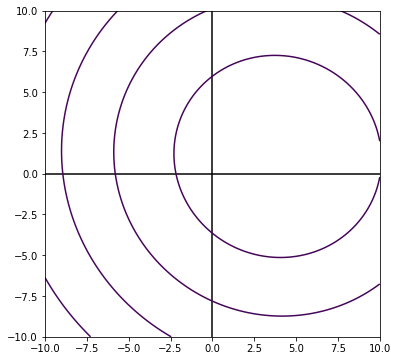

In [6]:
plot_objective(X, y)

**Exercise 1.2**: Fit an unregularized linear regression model, and plot the value with the given function.

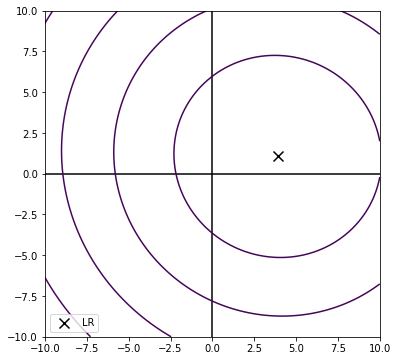

In [7]:
from sklearn.linear_model import LinearRegression

## <YOUR CODE HERE>
beta = LinearRegression().fit(X, y).coef_

plot_objective(X, y, beta=beta)

Recall that the ridge regression objective is given by
$$
L_2(\beta) = \frac{1}{2n}\sum_{i=1}^n (y_i - \beta^\top x_i)^2 + \lambda ||\beta||_2^2
$$
where
$$
||\beta||_2 = \sqrt{\sum_{j=1}^d \beta_j}.
$$

**Exercise 1.3**: Choose the value of `alpha` (the `sklearn` regularization constant) that corresponds to the our choice of `lambda_` above. Use this to fit a `Ridge` and `Lasso` model on the data, and plot the solution. (Hint: consult the `sklearn` documentation.)

[1.22512479 0.35363531]
[2.82988963 0.        ]


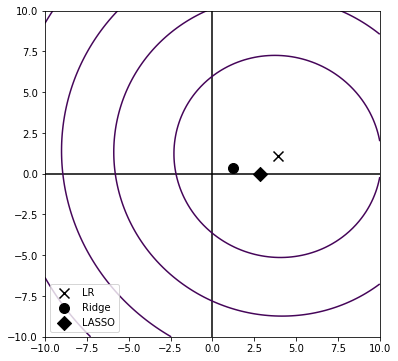

In [8]:
from sklearn.linear_model import Ridge, Lasso

lambda_ = 1.1
n = len(X)

# Ridge
alpha_r = 2 * n * lambda_ ## <YOUR CODE HERE>
beta_r = Ridge(alpha=alpha_r).fit(X, y).coef_ ## <YOUR CODE HERE>

# LASSO
alpha_l = lambda_ ## <YOUR CODE HERE>
beta_l = Lasso(alpha=alpha_l).fit(X, y).coef_ ## <YOUR CODE HERE>

print(beta_r)
print(beta_l)

plot_objective(X, y, beta=beta, beta_r=beta_r, beta_l=beta_l)

It can be proved that the optimal solution for both $\ell^1$ and $\ell^2$ regularized regression can be written in the form
\begin{align*}
    &\min_{\beta \in \mathbb{R}^n} \frac{1}{2n}\sum_{i=1}^n (y_i - \beta^\top x_i)^2\\
    &\text{subject to } ||\beta||_p \leq s_p^\lambda
\end{align*}
where $s^\lambda_p$ depends on $\lambda$ and $p = 1, 2$.

We have the following intuition in two dimensions.
- For $\ell^2$ regularization, this can be interpreted as finding the best $\beta$ within a circle centered at the origin with length $s_2^\lambda$.
- For $\ell^1$ regularization, this can be interpreted as finding the best $\beta$ within a diamond centered at the origin with side length $s_1^\lambda \sqrt{2}$.

**Exercise 1.4**: Plot the $\ell^1$ and $\ell^2$ balls on our plot using the `l1` and `l2` arguments. Adjust the values of `s1` and `s2` so that the LASSO solution is on the diamond and the ridge solution is on the circle. Can you guess analytically what these values should be?

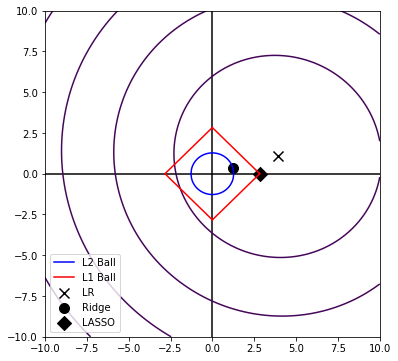

In [9]:
## <YOUR CODE HERE>
s1 = np.linalg.norm(beta_l)
s2 = np.linalg.norm(beta_r)

plot_objective(X, y, beta=beta, beta_r=beta_r, beta_l=beta_l, l2=s2, l1=s1)

LASSO tends to pick *sparse* solutions, because the countours of the objective function (assuming the unregularized solution is outside the ball) touch the $\ell^1$ ball at its corners.

### 1.3. Forward Stepwise Selection

The LASSO might seem like an indirect method to estimate the best subset of variables. Can you think of a "brute force" method to determine the best subset? 

One could just train and test every single subset of variables in the dataset, but that would require $2^d$ training and evaluation loops, and even more if we evaluate multiple metrics per model. *Forward stepwise regression* is a compromise in which we search progressively larger model classes until reaching a reasonable subset of features.

**Algorithm 1.1: Forward stepwise selection** (ISLR)

1. Let $\mathcal{M}_0$ denote the *null* model, which contains no predictors (i.e. return $\bar{y}$).
2. Let $k = 0, ..., d$:
    - Start with model $\mathcal{M}_k$. The subscript $k$ indexes the number of features included in this model. Thus, there are $d - k$ remaining features.
    - Evaluate on the training set all models that contain the $k$ features of $\mathcal{M}_k$, augmented with one of the remaining $d-k$ features ($k+1$ features total).
    - Select the best among these $d - k$ models, and call that $\mathcal{M}_{k+1}$.
3. Select the single best model among $\mathcal{M}_0, ..., \mathcal{M}_d$ using a metric on the validation set.

**Exercise 1.5**: How many total models are trained in the forward stepwise regression procedure?

**Solution**:

- Inner Loop: $d - k$ models.
- Outer Loop: Summed over $d+1$ choices of model size.
$$
\sum_{k=0}^{d} d - k = (d+1)d - \sum_{k=0}^{d} k = (d+1)d - \frac{(d+1) d}{2} = \frac{(d+1) d}{2}
$$

Given the above run times, it is quite remarkable that the LASSO is able to perform model training and feature selection *at the same time*. This explains why it is generally the preferred method for feature selection.

### 1.4. K-Fold Cross Validation

As in other settings, we have a hyperparameter to tune, namely the *regularization constant* $\lambda$. A large value of $\lambda$ induces an increase in bias and decrease in variance, whereas a small value of $\lambda$ induces a decrease in bias and increase in variance. Thus, we use a hold out set to select the best choice of this hyperparameter. In previous labs, we have seen five-by-two validation. $K$-fold cross validation is another popular method to select hyperparameters.

**Algorithm 1.2: K-fold cross validation**

Let $\mathcal{T} = (x_1, y_1), ..., (x_n, y_n)$ be the training set, and $\mathcal{H}$ be the set of hyperparameter settings that we would like to evaluate.
1. For each $\lambda \in \mathcal{H}$: 
    1. Partition the training set $\mathcal{T}$ into $K$ "folds" $\mathcal{T}_1, ..., \mathcal{T}_K$, each with $\frac{n}{K}$ data points.
    2. For folds $j = 1, ..., K$:
        1. Consider $\mathcal{T}_j$ as the validation set, and pool $\mathcal{T}_1, ..., \mathcal{T}_{j-1}, \mathcal{T}_{j+1}, ..., \mathcal{T}_{K}$ to form the training set.
        2. Train the model with hyperparameter setting $\lambda$ on the training set and evaluate on the validation set.
    3. Average the $K$ evaluation metrics from each fold (say accuracy or RSS), and consider this the performance of $\lambda$.
2. Return the $\lambda \in \mathcal{H}$ with the best performance.

**Exercise 1.6**: Implement $K$-fold cross validation to select the best choice of $\lambda$ for the LASSO.

In [10]:
from sklearn.metrics import mean_squared_error

def get_fold_indices(n, K, j):
    # <YOUR-CODE-HERE>
    # TODO: deal with the case when n is not a multiple of K.
    fold_size = n // K
    
    idx = np.arange(n)
    val_idx = idx[j * fold_size : (j+1) * fold_size]
    
    if j == 0: 
        train_idx = idx[fold_size : n]
    elif j == K-1:
        train_idx = idx[0 : (K-1) * fold_size]
    else:
        first_range = idx[0 : j * fold_size]
        second_range = idx[(j+1) * fold_size : n]
        train_idx = np.concatenate((first_range, second_range))
    
    return train_idx, val_idx

def K_fold_cross_validation(lambdas, X, y, K):
    
    n = len(X)
    best_model = None
    best_lambda = None
    best_performance = np.inf
        
    for i, lambda_ in enumerate(lambdas):
        
        print("---------------------------------------------------")
        print("Evaluating lambda =", lambda_, end="")
        
        # <YOUR-CODE-HERE>: How long should this array be?
        mses = np.zeros(K)
        for j in range(K):
            
            print(".", end="")
            
            # Subset into training and validation set.
            train_idx, val_idx = get_fold_indices(n, K, j)
            X_train, y_train = X[train_idx], y[train_idx]
            X_val, y_val = X[val_idx], y[val_idx]
            
            # Train on the training set.
            # <YOUR-CODE-HERE>
            alpha = lambda_
            
            model = Lasso(alpha=alpha).fit(X_train, y_train)
            
            # Evaluate on the validation set.
            # <YOUR-CODE-HERE>
            mses[j] = mean_squared_error(model.predict(X_val), y_val)
        
        performance = mses.mean()
        print("")
        print("Average MSE:", performance)
        print("---------------------------------------------------")
        
        # <YOUR-CODE-HERE>
        if performance < best_performance:
            best_performance = performance
            best_model = model
            best_lambda = lambda_
            
    return best_model, best_lambda, best_performance

Let us apply this to the `Hitters` dataset, and reproduce ISLR page 255. This is a dataset with 322 observations of major league players on the following 20 variables.

- `AtBat` - Number of times at bat in 1986
- `Hits` - Number of hits in 1986
- `HmRun` - Number of home runs in 1986
- `Runs` - Number of runs in 1986
- `RBI` - Number of runs batted in in 1986
- `Walks` - Number of walks in 1986
- `Years` - Number of years in the major leagues
- `CAtBat` - Number of times at bat during his career
- `CHits` - Number of hits during his career
- `CHmRun` - Number of home runs during his career
- `CRuns` - Number of runs during his career
- `CRBI` - Number of runs batted in during his career
- `CWalks` - Number of walks during his career
- `League` - A factor with levels A and N indicating player's league at the end of 1986
- `Division` - A factor with levels E and W indicating player's division at the end of 1986
- `PutOuts` - Number of put outs in 1986
- `Assists` - Number of assists in 1986
- `Errors` - Number of errors in 1986
- `Salary` - 1987 annual salary on opening day in thousands of dollars
- `NewLeague` - A factor with levels A and N indicating player's league at the beginning of 1987

The response variable is `Salary`.

In [11]:
hitters_data = pd.read_csv('Hitters.csv').dropna()
hitters_data.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [12]:
hitters_data_transformed = pd.get_dummies(hitters_data, drop_first=True)
hitters_data_transformed.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League_N,Division_W,NewLeague_N
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,1,0,1
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,1,0,1
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,0,1,0


In [13]:
col_names = list(hitters_data_transformed.columns)
col_names.pop(16)
print(col_names)

['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors', 'League_N', 'Division_W', 'NewLeague_N']


In [14]:
y_full = hitters_data_transformed["Salary"].to_numpy()
X_full = hitters_data_transformed[col_names].to_numpy()

# Split the data into train and test set.
X, X_test, y, y_test = train_test_split(X_full, y_full, test_size=0.20) 

# Standardize the train and test design matrix.
scaler = StandardScaler().fit(X)
X = scaler.transform(X)
X_test = scaler.transform(X_test)

In [15]:
K = 5
lambdas = np.logspace(0.38, 1, 10)

best_model, best_lambda, best_performance = K_fold_cross_validation(lambdas, X, y, K)
print("BEST LAMBDA:", best_lambda)

---------------------------------------------------
Evaluating lambda = 2.3988329190194904.....
Average MSE: 139106.294812177
---------------------------------------------------
---------------------------------------------------
Evaluating lambda = 2.8111815178699864.....
Average MSE: 138653.09172708448
---------------------------------------------------
---------------------------------------------------
Evaluating lambda = 3.294410987841538.....
Average MSE: 138344.4245752117
---------------------------------------------------
---------------------------------------------------
Evaluating lambda = 3.860705432153813.....
Average MSE: 138104.6918702491
---------------------------------------------------
---------------------------------------------------
Evaluating lambda = 4.524343346616745.....
Average MSE: 138012.2823007799
---------------------------------------------------
---------------------------------------------------
Evaluating lambda = 5.302057636304972.....
Average MSE: 

/Users/avsharma/opt/anaconda3/envs/DATA558/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5528.211098605767, tolerance: 3646.8334512291663
  positive)
/Users/avsharma/opt/anaconda3/envs/DATA558/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:532: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6083.678852887824, tolerance: 3646.8334512291663
  positive)


In [16]:
# Compare to sklearn implementation.
from sklearn.linear_model import LassoCV

print(LassoCV(alphas=lambdas, cv=K).fit(X, y).alpha_)

10.0


/Users/avsharma/opt/anaconda3/envs/DATA558/lib/python3.7/site-packages/sklearn/linear_model/_coordinate_descent.py:528: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8161.926148440689, tolerance: 3646.8334512291663
  tol, rng, random, positive)


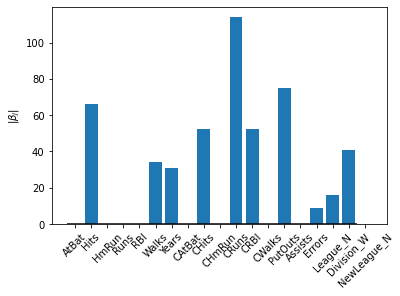

In [17]:
# Visualize the betas.
beta = best_model.coef_
plt.bar(np.arange(len(beta)), np.abs(beta), tick_label = col_names)
plt.hlines(y=0, color='k', xmin=-0.5, xmax=17.5)
plt.xticks(rotation = 45)
plt.ylabel(r"$|\beta_j|$")
plt.show()

## 2. Coordinate Descent

Thus far in the course we have discussed and implemented two optimization algorithms: gradient descent and fast gradient descent. Both algorithms are _iterative_ and make use of _first-order_ (i.e. gradient) information to generate a sequence of iterates that converges to a minimizer of the objective function.

We'll now consider a third algorithm, coordinate descent, that takes a somewhat different approach. GD and FGD update all parameters at every iteration by taking a step in the direction of the gradient. By contrast, coordinate descent focuses on one parameter at a time (holding the others constant) and takes a step that _exactly optimizes_ the objective considered as a function of that one parameter.

An outline of the algorithm is written below. We assume that the function to be minimized, $L(\beta)$, has a $d$-dimensional parameter, i.e. $\beta \in \mathbb{R}^d$, so that we can equivalently write $L(\beta) = L(\beta_1, ..., \beta_d)$.


`Algorithm: Coordinate Descent`

`initialize` $\beta = \beta^{(0)}$

`while not converged:`

- `select dimension` $j \in \{1, ..., d\}$
    
- `fix all parameters` $\beta_{j'}$ `such that` $j' \neq j$
    
- `update` $\beta_j = \text{argmin}_{\theta} \ \ L(\beta_1, ..., \beta_{j-1}, \theta, \beta_{j+1}, ..., \beta_d)$

`return` $\beta$

### 2.1 Coordinate descent for the ridge regression objective

Let's see how this is implemented for the ridge regression objective

$$
L_2(\beta) = \frac{1}{2n}||y - X\beta||_2^2 + \lambda ||\beta||_2^2.
$$

The main step in coordinate descent is the minimization over the coordinate $\beta_j$. Note that we can write the objective as

$$
L_2(\beta) = \frac{1}{2n}||y - X_{-j}\beta_{-j} - X_j\beta_j||_2^2 + \lambda \left(||\beta_{-j}||_2^2 + \beta_j^2\right) ,
$$


where we use the notation $X_{-j}$ and $\beta_{-j}$ to indicate the removal of the $j^{th}$ column or element, respectively.


For ridge regression, we can derive the update

$$
\beta_j = \text{argmin}_{\theta} \ \ L_2(\beta_1, ..., \beta_{j-1}, \theta, \beta_{j+1}, ..., \beta_d)
$$

in closed form. We'll do this (and then implement it) as a sequence of exercises.

__Exercise 2.1__: Compute the partial derivative $\frac{\partial}{\partial \beta_j} L_2(\beta)$, using the form of the ridge objective that separates $\beta_j$ from $\beta_{-j}$.

_Solution_:


Define $r_j = y-X_{-j}\beta_{-j}$. Then

$$
\frac{\partial}{\partial \beta_j} L_2(\beta) = -\frac{1}{n} X_j^T(r_j - X_j\beta_j) + 2\lambda \beta_j.
$$

__Exercise 2.2__: Find the update rule for $\beta_j$ by setting the partial derivative from __Ex. 3.1__ equal to zero and solving for $\beta_j$.

_Solution_:

We set

$$
-\frac{1}{n} X_j^T(r_j - X_j\beta_j) + 2\lambda \beta_j = (\frac{1}{n}X_j^TX_j + 2\lambda)\beta_j - \frac{1}{n}X_j^Tr_j = 0.
$$

Solving for $\beta_j$ yields

$$
\beta_j = \frac{\frac{1}{n} X_j^Tr_j}{\frac{1}{n}X_j^TX_j + 2\lambda}.
$$

__Exercise 2.3__: Implement this update rule in the coordinate descent code provided below.

In [18]:
def coorddescent(beta_init, X, y, lam, max_iter=20):
    d = X.shape[1] # initialize
    it = 0
    iterates = [beta_init]
    
    while it < max_iter:
        j = np.random.choice(d) # select a random dimension
        
        Xj = X[:, j] # form X_j, X_{-j}, and beta_{-j}
        Xnj = np.hstack((X[:, :j], X[:, (j+1):]))
        beta = iterates[-1]
        bnj = np.concatenate((beta[:j], beta[(j+1):]))
        
        ## <YOUR CODE HERE>
        resid = y-np.dot(Xnj, bnj)
        bj = (1/n*np.dot(Xj, resid)) / (2*lam + (1/n)*np.linalg.norm(Xj)**2)

        new_beta = copy.copy(beta)
        new_beta[j] = bj
        iterates.append(new_beta)
        it += 1
        
    return np.array(iterates)

Let's visualize the results and compare to gradient descent.

In [19]:
# plotting code
def generate_data1(n, d, scale, beta):
    cov = np.array([[1.0, 0.35],[0.35, 1.0]])
    X = np.dot(np.random.normal(size=(n,d)), cov)
    X[:, 0] = X[:, 0] * scale    
    y = np.dot(X, beta) + np.random.normal(size=n)
    
    return X, y

def generate_data2(n, d, k, scale):
    X = np.random.normal(size=(n,d))
    
    beta = np.zeros(d)
    supp_ix = np.random.choice(d, size=k, replace=False)
    beta[supp_ix] = (np.random.normal(size=k)+5.0) * np.sign(np.random.normal(size=k))
    y = np.dot(X, beta) + np.random.normal(size=n)
    
    return X, y, beta
    
def obj(beta, X, y, lam):
    return 1/2*np.mean((y-np.dot(X, beta))**2) + lam*np.linalg.norm(beta)**2

def plot_objective(X, y, iterates=None, levels=None, color='k'):
    nb = 100
    brange = np.linspace(-10, 10, nb)
    b1, b2 = np.meshgrid(brange, brange)
    z = np.array([obj(x, X, y, lam) for x in zip(b1.ravel(), b2.ravel())])
    
    if levels is None:
        levels=np.logspace(-2,4,30)
    
    plt.contour(brange, brange, z.reshape((nb, nb)), levels=levels);
    
    if iterates is not None:
        # Points.
        plt.plot(iterates[:,0], iterates[:,1], '.', color=color);
        
        # Arrows.
        for j in range(1, len(iterates)):
            plt.annotate(
                "",
                xy=iterates[j],
                xytext=iterates[j - 1],
                arrowprops={"arrowstyle": "->", "color": color, "lw": 1},
                va="center",
                ha="center",
            )

In [20]:
# GD code
def computegrad(beta, X, y, lam):
    n = len(X)
    return -1/n * np.dot(X.T, y-np.dot(X, beta)) + 2*lam*beta

def graddescent(beta_init, eta, X, y, lam, max_iter=20):
    """Run gradient descent with a fixed step size
    Inputs:
    - beta_init: Starting point
    - eta: Step size (a constant)
    - max_iter: Maximum number of iterations to perform
    Output:
    - beta_vals: Matrix of estimated betas at each iteration,
                with the most recent values in the last row.
    """
    beta = beta_init
    grad_beta = computegrad(beta, X=X, y=y, lam=lam)
    beta_vals = [beta]
    iter_num = 0
    while iter_num < max_iter:
        beta = beta - eta*grad_beta
        beta_vals.append(beta)
        grad_beta = computegrad(beta, X=X, y=y, lam=lam)
        iter_num += 1
        
    return np.array(beta_vals)

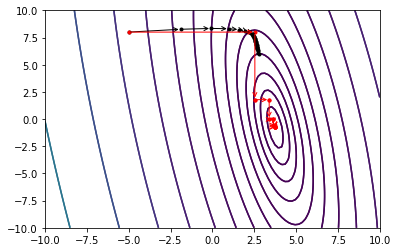

In [21]:
np.random.seed(123)

n = 20
d = 2
scale = 5
beta = np.array([4.0, -2.0])
lam = 0.5
X, y = generate_data1(n, d, scale, beta)

beta_init = np.array([-5.0, 8.0])
eta = 0.01
GD_iterates = graddescent(beta_init, eta, X, y, lam, max_iter=20)
CD_iterates = coorddescent(beta_init, X, y, lam, max_iter=20)


plot_objective(X, y, iterates=GD_iterates)
plot_objective(X, y, iterates=CD_iterates, color='red')

Compare to sklearn results:

In [22]:
from sklearn.linear_model import Ridge, Lasso

In [23]:
print('sklearn parameters: {}'.format(Ridge(alpha=lam*2*n, fit_intercept=False).fit(X, y).coef_))

sklearn parameters: [ 3.74544038 -0.76478525]


In [24]:
print('coord descent parameters: {}'.format(CD_iterates[-1]))

coord descent parameters: [ 3.74291944 -0.75945225]


In [25]:
print('grad descent parameters: {}'.format(GD_iterates[-1])) # not converged!

grad descent parameters: [2.77375902 5.97645686]


### 2.2 The regularization path

A key perspective in penalized estimation is to understand the general behavior of the estimator $\hat{\beta}_\lambda$, which is defined as the solution to the optimization problem

$$
\hat{\beta}_\lambda = \text{argmin}_\beta \ \ \frac{1}{2n}||y - X\beta||_2^2 + \lambda \Omega(\beta)
$$

as a function of the regularization parameter $\lambda \geq 0$. In the above, we use $\Omega(\beta)$ as a general stand-in for the various types of penalty we might use; so far in this course, we have seen $\Omega(\beta) = ||\beta||_2^2$ (ridge regression) and $\Omega(\beta) = ||\beta||_1$ (Lasso).


One way to build visual intuition is to plot the _regularization path_ of the parameters, that is, the sequence of values taken by each component of $\hat{\beta}_\lambda$ as we vary $\lambda$ over some range.

In [26]:
def compute_ridge_reg_path(X, y, lam_range):
    n = X.shape[0]
    coefs = []
    for lam in lam_range:
        ## <YOUR CODE HERE>
        coefs += [Ridge(alpha=2*n*lam).fit(X, y).coef_]
        
    return np.array(coefs)

def plot_reg_path(coefs, lam_range):
    d = coefs.shape[1]
    for j in range(d):
        log_decreasing_lams = np.log(lam_range)[::-1]
        plt.plot(np.log(lam_range), coefs[:,j], label='Component {}'.format(j))
        
    plt.gca().invert_xaxis() # plot w/ lambda decreasing from left to right
    plt.xlabel(r'$\log \lambda$')
    plt.ylabel('Ridge parameter')
    plt.legend(frameon=False, loc='upper left', fontsize=10)
    plt.show()

In [27]:
n = 100
d = 5
k = 5
scale = 5
X, y, beta = generate_data2(n, d, k, scale)

In [28]:
lam_range = np.logspace(-3,3,20)
params = compute_ridge_reg_path(X, y, lam_range)

In [36]:
params

array([[-6.38224414e+00,  5.06991553e+00, -4.81159789e+00,
         5.20978129e+00,  5.73240449e+00],
       [-6.36987343e+00,  5.05252527e+00, -4.79761928e+00,
         5.19213128e+00,  5.71879668e+00],
       [-6.34441990e+00,  5.01690468e+00, -4.76895480e+00,
         5.15597588e+00,  5.69087480e+00],
       [-6.29235909e+00,  4.94471526e+00, -4.71072994e+00,
         5.08269161e+00,  5.63408275e+00],
       [-6.18717259e+00,  4.80152274e+00, -4.59470224e+00,
         4.93728611e+00,  5.52059133e+00],
       [-5.97985996e+00,  4.52923568e+00, -4.37204583e+00,
         4.66065579e+00,  5.30148498e+00],
       [-5.59085982e+00,  4.05086012e+00, -3.97403682e+00,
         4.17430967e+00,  4.90468467e+00],
       [-4.92509811e+00,  3.31738898e+00, -3.34490967e+00,
         3.42807310e+00,  4.25995516e+00],
       [-3.94892361e+00,  2.40102364e+00, -2.52028801e+00,
         2.49502247e+00,  3.36901508e+00],
       [-2.79965416e+00,  1.51461930e+00, -1.66894362e+00,
         1.58989360e+00

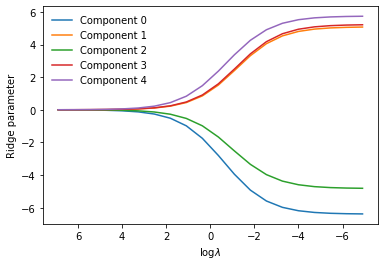

In [29]:
plot_reg_path(params, lam_range)

__Exercise 2.4__: Substitute your own implementation of coordinate descent for the sklearn version in the regularization path code above. Your method should produce (nearly) identical results.

### 2.3 Subgradients

In the above, we solved the coordinate-wise minimization problem by solving the optimality condition

$$
\frac{\partial}{\partial \beta_j} L = 0
$$

at every iteration. This approach is not applicable when $L$ is not differentiable as a function of $\beta_j$ - for example, when $L$ is the Lasso objective

$$
L(\beta) = \frac{1}{2n}||y - X\beta||_2^2 + \lambda ||\beta||_1.
$$

Instead, we need to use the concept of the _subgradient_.


__Definition__: A _subgradient_ of a function $f$ at $x$ is _any quantity_ $g$ satisfying

$$
f(z) \geq f(x) + g^T (z-x) \ \ \text{ for all } z.
$$

__Definition__: The _subdifferential_ of $f$ at $x$ is the set of all subgradients of $f$ at $x$. It is denoted by $\partial f(x)$.


Two important properties:
1. A convex function $f$ is differentiable at $x$ if and only if the subdifferential $\partial f(x)$ consists of a single point.
2. The point $x$ is a global minimum of $f$ if and only if $0 \in \partial f(x)$.

Property (2) generalizes the optimality condition for differentiable functions to _subdifferentiable_ functions, such as the Lasso objective. We can use this for coordinate descent!

In particular, we have seen in the lecture that the subgradient optimality condition yields a solution in terms of the soft thresholding function in the case of the Lasso problem (writing $L(\beta_j)$ to indicate that we are considering the Lasso objective $L$ a function of $\beta_j$ only for the coordinate descent sub-problem):

$$
0 \in \partial L(\beta_j) \implies \beta_j = S(\gamma_j, \eta_j, \lambda),
$$

where the soft-thresholding function $S$ is given by

$$
S(\gamma_j, \eta_j, \lambda) = \begin{cases} \frac{\gamma_j - \lambda}{\eta_j} & \gamma_j > \lambda \\ 0 & -\lambda \leq \gamma_j \leq \lambda \\ \frac{\gamma_j + \lambda}{\eta_j} & \gamma_j < -\lambda \end{cases},
$$

and 
$$
\gamma_j = \frac{1}{n} X_j^T(y-X_{-j}^T\beta_{-j}) \\
\eta_j = \frac{1}{n} X_j^TX_j.
$$ 

__Exercise 2.5__: Implement the soft-threshold function.

In [30]:
def soft_threshold(gamma, eta, lam):
    '''
    See HW4 solutions.
    '''

### 2.4 Coordinate descent for the Lasso

Finally, let's put the above two sections together to implement our own optimization algorithm for the Lasso objective - our first nonsmooth optimization problem. Note that neither GD nor fast GD is applicable here, as the Lasso objective is not differentiable.

__Exercise 2.6__: Re-implement coordinate descent, this time for the Lasso objective.

__Exercise 2.7__: Generate data from the `generate_data2()` function, then compute regularization paths for _both_ ridge regression and the Lasso on this data. Plot the regularization paths, either together or side-by-side. How does the regularization path of the Lasso compare to that of ridge regression?

In [31]:
def coorddescent_lasso(beta_init, X, y, lam, max_iter=20):
    d = X.shape[1] # initialize
    it = 0
    iterates = [beta_init]
    
    while it < max_iter:
        '''
        See HW4 solutions.
        '''
    
        new_beta = copy.copy(beta)
        new_beta[j] = soft_threshold(gamma, eta, lam)
        iterates.append(new_beta)
        it += 1
        
    return np.array(iterates)

As always, we can compare our implementation to sklearn to check for correctness.

In [32]:
n = 100
d = 50
k = 20
scale = 5
lam = 1.0
X, y, beta = generate_data2(n, d, k, scale)

X = X-np.mean(X, axis=0)
y = y-np.mean(y)

In [33]:
beta

array([ 0.        ,  0.        ,  4.57109839,  0.        ,  0.        ,
        5.47352486,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -2.52143921,  4.43375432,  0.        , -5.27789076,
       -3.43052745, -4.05864218,  0.        , -5.74735922,  0.        ,
        4.71237914,  0.        ,  0.        ,  5.11468039,  0.        ,
       -6.51999898,  0.        , -5.24744217,  0.        , -4.29322129,
        0.        ,  0.        ,  0.        ,  5.23250015,  0.        ,
        0.        ,  0.        ,  5.64069926,  0.        ,  5.02913409,
        0.        ,  0.        ,  0.        ,  3.6913096 ,  0.        ,
       -3.50960491,  5.50864037, -4.36037263,  0.        ,  0.        ])

In [34]:
la = Lasso(alpha=lam).fit(X,y)
la.coef_

array([-0.        ,  0.        ,  5.33972439, -0.        ,  0.        ,
        4.34465214,  0.        , -0.        , -0.        , -0.        ,
        0.        , -0.75707096,  2.16274144,  0.86809311, -4.25941536,
       -1.93930344, -3.39945976,  0.        , -3.3297463 ,  0.        ,
        5.02499038,  0.        , -0.        ,  4.55238661, -0.        ,
       -5.43718019, -0.        , -3.91662411,  0.        , -1.99263844,
       -0.        , -0.        ,  0.        ,  3.53429781,  0.        ,
        0.        ,  0.        ,  4.28404432,  0.        ,  4.24647574,
       -0.        ,  0.        , -0.        ,  2.48388791,  0.        ,
       -1.60201486,  3.18139349, -2.42577423,  0.        ,  0.        ])

In [35]:
beta_init = np.random.normal(size=d)
CD_iterates = coorddescent_lasso(beta_init, X, y, lam, max_iter=2000)

NameError: name 'gamma' is not defined

In [ ]:
CD_iterates[-1]

In [ ]:
np.sum(np.logical_and(CD_iterates[-1]>0, beta>0)) # positive coefficients found

In [ ]:
np.sum(np.logical_and(CD_iterates[-1]>0, beta==0)) # false positives